**To do:**
* ~~Expand dataset -> Use Q2 prompts as well~~
    * ~~Train/Val or Train/Val/Test~~
* ~~Expand to multilabel prediction~~
* More epochs
* Check if NPU acceleration is usable (often not with small matrices
* Test with absolute loss instead of MSE
* Round outputs to nearest decimal/floor to number beofore dedimal pt -> check performance (test run)
* Calculate loss over epoch/loss per batch
* Validate -> after each training epoch
* NLP cleanups
    * Text cleanup (spelling/grammar/punctuation errors)
    * Check max length of answers
* Try different language models
* Try different network architectures/activation functions
    * TanH -> ReLU or vice versa
* Show significant tokens

## Data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Importing stock ml libraries
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel
from matplotlib import pyplot as plt
import logging
logging.basicConfig(level=logging.ERROR)

### Data Import and Filtering

In [3]:
# Clean up the 2 datasets
df1 = pd.read_excel("3 Watching More Closely - human coded complete - already published/Watching More Closely Data MSA.xlsx")
df2 = pd.read_excel("4 VR Coffee Without Words/5 VEC Data MSA.xlsx")

# Drop unnecessary rows and columns
df1.drop(columns = ["ID", "DataSet ", "V1", "Q1.4", "Q1.8", "Q2.4", "Q2.8", "Unnamed: 13", "Unnamed: 22",
                    "Q1_letter_count", "Q1_word_count", "Q2_letter_count", "Q2_word_count"], inplace = True)
df1.drop([0], inplace = True)
df1.dropna(axis = 0, inplace = True)

for col in list(df1.columns)[2:]:
    df1 = df1[df1[col] > -1]

df2_cols_remove = list(df2.columns)
df2_cols_keep = ['CJ_tend', 'CJ_abil', 'CJ_tend_cog_self', 'CJ_tend_aff_self', 'CJ_tend_int_self',
                    'CJ_tend_cog_target', 'CJ_tend_aff_target', 'CJ_tend_int_target',
                    'CJ_abil_cog_self', 'CJ_abil_aff_self', 'CJ_abil_int_self',
                    'CJ_abil_cog_target', 'CJ_abil_aff_target', 'CJ_abil_int_target']
for col in df2_cols_keep:
    if col in df2_cols_remove:
        df2_cols_remove.remove(col)
df2.drop(columns = df2_cols_remove, inplace = True)
df2.dropna(inplace = True)

In [4]:
data1_1 = pd.DataFrame()
data1_2 = pd.DataFrame()
data2_1 = pd.DataFrame()
data2_2 = pd.DataFrame()

df1_q1_cols = ["Q1", "Q1.1", "Q1.2", "Q1.3", "Q1.5", "Q1.6", "Q1.7"]
df1_q2_cols = ["Q2", "Q2.1", "Q2.2", "Q2.3", "Q2.5", "Q2.6", "Q2.7"]
df2_q1_cols = ["CJ_tend", "CJ_tend_aff_target", "CJ_tend_cog_target", "CJ_tend_int_target",
           "CJ_tend_aff_self", "CJ_tend_cog_self", "CJ_tend_int_self"]
df2_q2_cols = ["CJ_abil", "CJ_abil_aff_target", "CJ_abil_cog_target", "CJ_abil_int_target",
           "CJ_abil_aff_self", "CJ_abil_cog_self", "CJ_abil_int_self"]

colNames = ["Q", "AFF_TAR", "COG_TAR", "INT_TAR", "AFF_OTH", "COG_OTH", "INT_OTH"]

for i in range(len(colNames)):
    data1_1[colNames[i]] = df1[df1_q1_cols[i]]
    data1_2[colNames[i]] = df1[df1_q2_cols[i]]
    data2_1[colNames[i]] = df2[df2_q1_cols[i]]
    data2_2[colNames[i]] = df2[df2_q2_cols[i]]

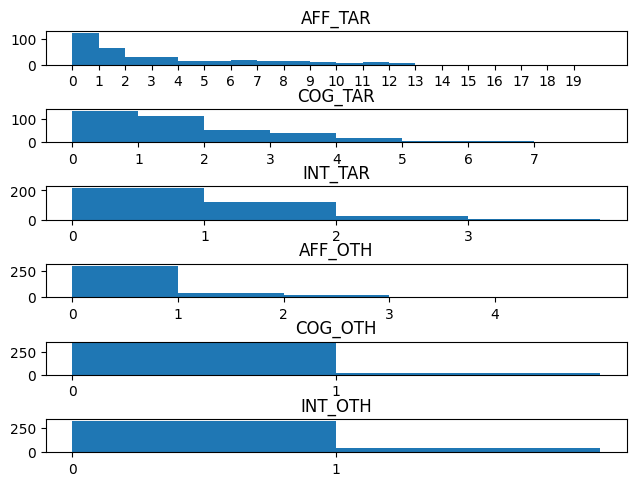

In [5]:
# Final dataset
df = pd.concat([data1_1, data1_2, data2_1, data2_2])
df.reset_index(drop=True, inplace=True)

fig, axs = plt.subplots(6,1)
fig.tight_layout()
for i, col in enumerate(list(df.columns)[1:]):
    axs[i].hist(df[col], bins = max(df[col]))
    axs[i].set_xticks(range(max(df[col])))
    axs[i].set_title(col)    

In [6]:
df.head()

,Q,AFF_TAR,COG_TAR,INT_TAR,AFF_OTH,COG_OTH,INT_OTH
0,"A child and a man, presumably the father, are ...",1,0,0,0,0,0
1,Scene opens with a father and daughter riding ...,1,1,0,0,0,0
2,The clip commences with a cross view of the gi...,0,3,1,1,0,0
3,A girl cycles with her father to see him off a...,0,1,1,0,0,0
4,A father and daughter are cycling through the ...,1,0,1,0,0,1


In [7]:
# Convert to vectorized targets
vectData = pd.DataFrame()
vectData["text"] = df["Q"]
vectData["labels"] = df.iloc[:,1:8].values.tolist()

# Train/val split
from sklearn.model_selection import train_test_split
trainData, testData = train_test_split(vectData, test_size = 0.2)
trainData.reset_index(drop = True, inplace = True)
testData.reset_index(drop = True, inplace = True)

In [8]:
trainData.head()

,text,labels
0,The girl is to focused on the cookie and is no...,"[0, 3, 1, 0, 0, 0]"
1,She must be quite anxious as she cycles with h...,"[5, 1, 0, 0, 0, 0]"
2,A father and daughter cycle through the countr...,"[0, 0, 0, 0, 0, 0]"
3,The father and daughter cycled along together ...,"[0, 1, 1, 0, 0, 0]"
4,If I were the daughter I would probably not ha...,"[11, 6, 0, 1, 0, 0]"


In [10]:
df.to_csv("dataset_non_vectorized.csv", index = False)
vectData.to_csv("dataset_vectorized.csv", index = False)

In [11]:
# Clear memory
del(df1, df2, data1_1, data1_2, data2_1, data2_2, df)

## TrainingLoader Setup

In [12]:
# Params
# To do: Look into tokenizer params
MAX_LEN = 256
TRAIN_BATCH_SIZE = 1
VALID_BATCH_SIZE = 1
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)

In [13]:
class MultiLabelDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

## Multiple Attribute Prediction

In [14]:
# Create dataset
train_multi = MultiLabelDataset(trainData, tokenizer, MAX_LEN)
test_multi = MultiLabelDataset(testData, tokenizer, MAX_LEN)

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(train_multi, **train_params)
test_loader = DataLoader(test_multi, **train_params)

In [15]:
class nn_multi(torch.nn.Module):
    def __init__(self):
        super(nn_multi, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.hiddenFCN = torch.nn.Linear(768,768)
        self.scoreOut = torch.nn.Linear(768, 6)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.hiddenFCN(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.scoreOut(pooler)
        return output

model_multi = nn_multi()

In [16]:
model_multi

nn_multi(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featur

In [17]:
# Training loop
# To do: send tensors to device
EPOCHS = 40
trainLoss = []
testLoss = []
#roundVals = True

loss_fn = torch.nn.MSELoss() # Use MSE since we're doing regression
optimizer = torch.optim.Adam(params = model_multi.parameters(), lr=1e-4)

for i in tqdm(range(EPOCHS)):
    model_multi.train()
    runningLossTrain = []
    runningLossVal = []
    for it, dataTrain in enumerate(training_loader):
        #print(data)
        ids = dataTrain['ids']
        mask = dataTrain['mask']
        token_type_ids = dataTrain['token_type_ids']
        targets = dataTrain['targets']

        outputs = model_multi(ids, mask, token_type_ids)
        outputs = outputs.sum(dim=1)
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()

        runningLossTrain.append(loss.item())

    model_multi.eval()
    for it, dataVal in enumerate(test_loader):
        ids = dataVal['ids']
        mask = dataVal['mask']
        token_type_ids = dataVal['token_type_ids']
        targets = dataVal['targets']

        outputs = model_multi(ids, mask, token_type_ids)
        outputs = outputs.sum(dim=1)
        loss = loss_fn(outputs, targets)

        runningLossVal.append(loss.item())

    trainLoss.append(sum(runningLossTrain) / it)
    testLoss.append(sum(runningLossVal) / it)

    if(i % 5 == 0):
        print("Epoch", i, ":\tTrain loss:", round(trainLoss[-1], 5),
              "\tEval loss:", round(testLoss[-1], 5))


  0%|          | 0/40 [00:00<?, ?it/s]

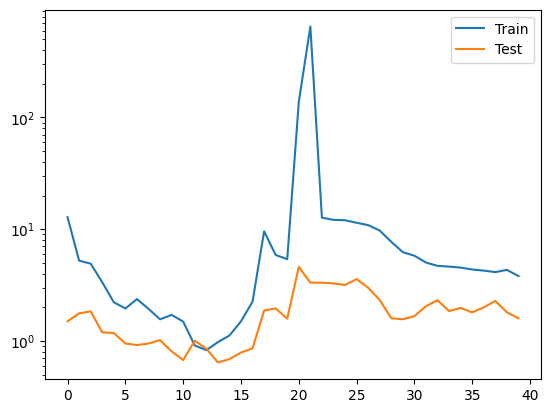

In [25]:
names = ["Train", "Test"]
plt.plot(trainLoss)
plt.plot(testLoss)
plt.yscale("log")
plt.legend(names)

In [29]:
# Save model
torch.save(model_multi, "model_FCN_TANH_RELU")

## Testing

In [68]:
# Load model
model_multi = torch.load("model_FCN_TANH_RELU.pt")
model_multi.eval()
loss_fn = torch.nn.MSELoss() # Use MSE since we're doing regression
optimizer = torch.optim.Adam(params = model_multi.parameters(), lr=1e-4)

# Visualization
labels = []
outputs_raw = []
outputs_rnd = []
outputs_flr = []

# Run on test set and visualize output vectors (with and without rounding/flooring)
for it, dataVal in enumerate(tqdm(test_loader)):
    ids = dataVal['ids']
    mask = dataVal['mask']
    token_type_ids = dataVal['token_type_ids']
    targets = dataVal['targets']

    outputs = model_multi(ids, mask, token_type_ids)
    outputs = outputs.sum(dim=1)
    loss = loss_fn(outputs, targets)

    outputs_no_grad = torch.tensor(outputs, requires_grad = False)
    outputs_raw.append(outputs_no_grad)
    outputs_rnd.append(torch.round(outputs_no_grad))
    outputs_flr.append(torch.floor(outputs_no_grad))
    labels.append(targets)
    
    #if(it == 9): break

  0%|          | 0/74 [00:00<?, ?it/s]

In [79]:
# Write results to .txt file
fileName = "ToM_out_1.txt"

for i in range(len(labels)):
    with open(fileName, "a") as log:
        log.write("True label:\t\t" + str(labels[i]) + "\n")
        log.write("Floored output:\t\t" + str(outputs_flr[i]) + "\n")
        log.write("Rounded output:\t\t" +str(outputs_rnd[i]) + "\n")
        log.write("Raw output:\t\t" +str(outputs_raw[i]) + "\n\n")